## retagImg
A notebook to pull in tags from a pretagged repository, run a function against them (in this case Computer Vision to get dominate color) and write the new tags back to the original repository.


In [ ]:
# install packages if needed
import sys
!{sys.executable} -m pip install azure-cognitiveservices-vision-customvision
!{sys.executable} -m pip install azureml-sdk
!{sys.executable} -m pip install azureml-contrib-dataset
!{sys.executable} -m pip install azure-storage-blob
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow


In [ ]:
## Steps per notebook cell
* pip requirements.txt
* imports
* custom user defined variables
* for... each image in repository
    * convert URL into document 
    * possibly convert from % to actual pixel counts
    * for... each tag1 in image
        * read dimentions, if it is less than 50 pixels expand both sides by 1 until it is at least 50x50
        * snip that byte stream send to "Computer Vision"
        * retrieve dominate color, add tag2 with color to image, and add tag1 " - " tag2 to image
        * write back to repository
* close out everything 
    


In [13]:
# From Laurens Ariel Import
import json, os, shutil
import azureml.contrib.dataset

from azureml.core import Workspace, Dataset, Datastore
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
# azureml-contrib-dataset of version 1.0.72 or higher is required

In [16]:
# From Laurens Ariel Import
subscription_id = '2fe7f70e-ab59-4d15-b475-b417edd1a5a3'
resource_group = 'ckahrsMantechRG'
workspace_name = 'ckahrsMantechAMLWS'
dataset_name = 'LabelSatImages-2020-05-19 13:53:25'

ws = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(ws, name=dataset_name)
df = dataset.to_pandas_dataframe()

In [38]:
# df['label'][0][0]
df.head()


,image_url,label,label_confidence,path_to_download
0,StreamInfo(AmlDatastore://coco/Satellite-Image...,"[{'label': 'car', 'topX': 0.6823267527445109, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",coco/Satellite-Image-2016-Olympics-Rio-De-Jane...
1,StreamInfo(AmlDatastore://coco/Satellite-Image...,"[{'label': 'car', 'topX': 0.23617339312406577,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",coco/Satellite-Image-2016-Olympics-Rio-De-Jane...
2,StreamInfo(AmlDatastore://coco/Satellite-Image...,"[{'label': 'car', 'topX': 0.05684262667999005,...","[1.0, 1.0, 1.0, 1.0]",coco/Satellite-Image-2016-Olympics-Rio-De-Jane...


In [31]:
# hack to extract datastore name - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
s = str(df.iloc[0].image_url) 
s = s.split('[')[1].split(']')[0]
s = s.replace("'", "\"") 
ds = json.loads(s)['datastoreName']

# get datastore
blob_datastore = Datastore.get(ws, ds)

# create temp directory for labeled dataset download
tmp_dir = '../tmp'
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# hack to extract path - no documentation on how to parse StreamInfo - TODO: parse StreamInfo correctly
df['path_to_download'] = df['image_url'].apply(lambda x: str(x).split('//')[1].split("[")[0])

In [33]:
df.loc[0, "path_to_download"]

'coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_100.jpg'

In [46]:
df['label'][0][0]['topX']

0.6823267527445109

In [49]:

# from azureml.contrib.dataset import FileHandlingOption
# satimg_pd = dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download/', overwrite_download=True)

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# #read images from downloaded path
# img = mpimg.imread(satimg_pd.loc[0,'image_url'])
# imgplot = plt.imshow(img)

im = Image.open(satimg_pd.loc[0,'image_url'])
im.size
topxpixel = df['label'][0][0]['topX'] * im.size[0]
topypixel = df['label'][0][0]['topY'] * im.size[1]
bottomxpixel = df['label'][0][0]['bottomX'] * im.size[0]
bottomypixel = df['label'][0][0]['bottomY'] * im.size[1]
print(topxpixel)
print(topypixel)
print(bottomxpixel)
print(bottomypixel)

349.3512974051896
202.5163890968064
370.7940993013972
212.09722742015967


## Playground


In [52]:
img.shape
 

(512, 512, 3)

In [51]:
# to show us the actual img snip we get from the coordinates
# import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
def crop(image, x1, x2, y1, y2):
    """
    Return the cropped image at the x1, x2, y1, y2 coordinates
    """
    if x2 == -1:
        x2=image.shape[1]-1
    if y2 == -1:
        y2=image.shape[0]-1
    mask = np.zeros(image.shape)
    mask[y1:y2+1, x1:x2+1]=1
    m = mask>0
    return image[m].reshape((y2+1-y1, x2+1-x1))
# img = sp.lena()
image_cropped = crop(img, 349,370,202,212)
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image)
ax2.imshow(image_cropped)
plt.show()

ValueError: cannot reshape array of size 726 into shape (11,22)

{
  "color": {
    "dominantColorForeground": "White",
    "dominantColorBackground": "Grey",
    "dominantColors": [
      "Grey",
      "White",
      "Black"
    ],
    "accentColor": "455E86",
    "isBwImg": false,
    "isBWImg": false
  },
  "requestId": "1ce84057-0e53-461b-bda8-7ce4ae09a804",
  "metadata": {
    "width": 65,
    "height": 85,
    "format": "Jpeg"
  }
}


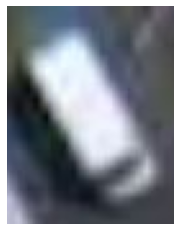

In [11]:
import requests

import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

# If you are using a Jupyter notebook, uncomment the following line.
%matplotlib inline

# Add your Computer Vision subscription key and endpoint to your environment variables.
subscription_key = 'b8397be385f54209a4b250d9a3d7f982'
endpoint = "https://eastus.api.cognitive.microsoft.com/"

analyze_url = endpoint + "vision/v2.1/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://ckahrsmantechstorage.blob.core.windows.net/mantech/veh1.JPG"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'visualFeatures': 'Color'}
data = {'url': image_url}
response = requests.post(analyze_url, headers=headers,
                         params=params, json=data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(json.dumps(response.json(), indent = 2, separators=(',', ': ')))


# Display the image and overlay it with the caption.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")

plt.show()

## Playground 2


In [4]:
from azure.storage.blob import BlobServiceClient, ContainerClient

blob_service_client = BlobServiceClient.from_connection_string("DefaultEndpointsProtocol=https;AccountName=ckahrsmantechstorage;AccountKey=FUjBTCqAW6pRv0u+004Hc6eXfh14ly26ZdgK6sVfugEhIMeaUY1fbgDbs6aJp6a77K4ZJrbsdaqLhSEMJTDqTg==;EndpointSuffix=core.windows.net")
all_containers = blob_service_client.list_containers(include_metadata=True)
for container in all_containers:
    print(container['name'], container['metadata'])
    container_client = blob_service_client.get_container_client(container['name'])
    generator = container_client.list_blobs()

    #code below lists all the blobs in the container and downloads them one after another
    for blob in generator:
        print("   " + blob.name)

mantech {}
   veh1.JPG
   veh2.JPG
   veh3.JPG
   veh4.JPG
   veh5.JPG
   veh6.JPG
   veh7.JPG
   veh8.JPG
   veh9.JPG
satimages {}
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_0.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_1.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_10.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_100.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_101.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_102.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_103.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_104.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_105.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_106.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_107.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_108.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_109.jpg
   coco/Satellite-Image-2016-Olympics-Rio-De-Janeiro_11.jpg
   coco/Satellite-Im